 * Copyright 2024 Xue_Lexiang
 * Licensed under MIT (https://github.com/xuelx1/LearnQC/LISENCE)

### Modular Addition and Multiplication

#### 1.Modular Adder Gate

In [49]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT
import numpy as np
import math

backend = AerSimulator()

In [50]:
def getAngles(a, N):
    s = bin(int(a))[2:].zfill(N)
    angles = np.zeros([N])
    for i in range(N):
        for j in range(i, N):
            if s[j] == '1':
                angles[N-i-1] += math.pow(2, i-j)
        angles[N-i-1] *= np.pi
        return angles


In [51]:
def phiADD(a, N, inv = 0):
    qc = QuantumCircuit(N)
    angels = getAngles(a, N)
    for i in range(N):
        if inv == 0:
            qc.p(angels[i], i)
        else:
            qc.p(-angels[i], i)
    qc = qc.to_gate()
    if inv == 0:
        qc.name = "phiADD %i" % (a)
    else:
        qc.name = "phiADD %i" % (-a)
    return qc

def cphiADD(a, N, inv = 0):
    qc = phiADD(a, N, inv).control()
    if inv == 0:
        qc.name = "cphiADD %i" % (a)
    else:
        qc.name = "cphiADD %i" % (-a)
    return qc

def ccphiADD(a, N, inv = 0):
    qc = QuantumCircuit(N+2)
    angle=getAngles(a, N)
    for i in range(N):
        if inv==0:
            qc.mcp(angle[i], [0, 1], i+2)
        else:
            qc.mcp(-angle[i], [0, 1], i+2)
    qc = qc.to_gate()
    if inv == 0:
        qc.name = "ccphiADD %i" % (a)
    else:
        qc.name = "ccphiADD %i" % (-a)
    return qc

In [52]:
def ccphiADDmodN(a, n, N):
    '''a N+3-qubit gate, first two qubits are the control
    from 3 to N+2 are qubits, which receive phase of b and return phase of a+b mod n
    the last qubit is the ancilla'''
    qc = QuantumCircuit(N+3)
    gate = ccphiADD(a, N)
    qc.append(gate, list(range(N+2)))
    qc.barrier()
    gate = phiADD(n, N, inv=1)
    qc.append(gate, list(range(2, N+2)))
    qc.barrier()
    qft_inv = QFT(N, do_swaps=False, inverse=True)
    qc.append(qft_inv, list(range(2, N+2)))
    qc.barrier()
    qc.cx(N+1, N+2)
    qc.barrier()
    qft = QFT(N, do_swaps=False)
    qc.append(qft, list(range(2, N+2)))
    qc.barrier()
    gate = cphiADD(n, N)
    qc.append(gate, [N+2] + list(range(2, N+2)))
    qc.barrier()
    gate = ccphiADD(a, N, inv=1)
    qc.append(gate, list(range(N+2)))
    qc.barrier()
    qc.append(qft_inv, list(range(2, N+2)))
    qc.barrier()
    qc.x(N+1)
    qc.cx(N+1, N+2)
    qc.x(N+1)
    qc.barrier()
    gate = ccphiADD(a, N)
    qc.append(gate, list(range(N+2)))
    return qc


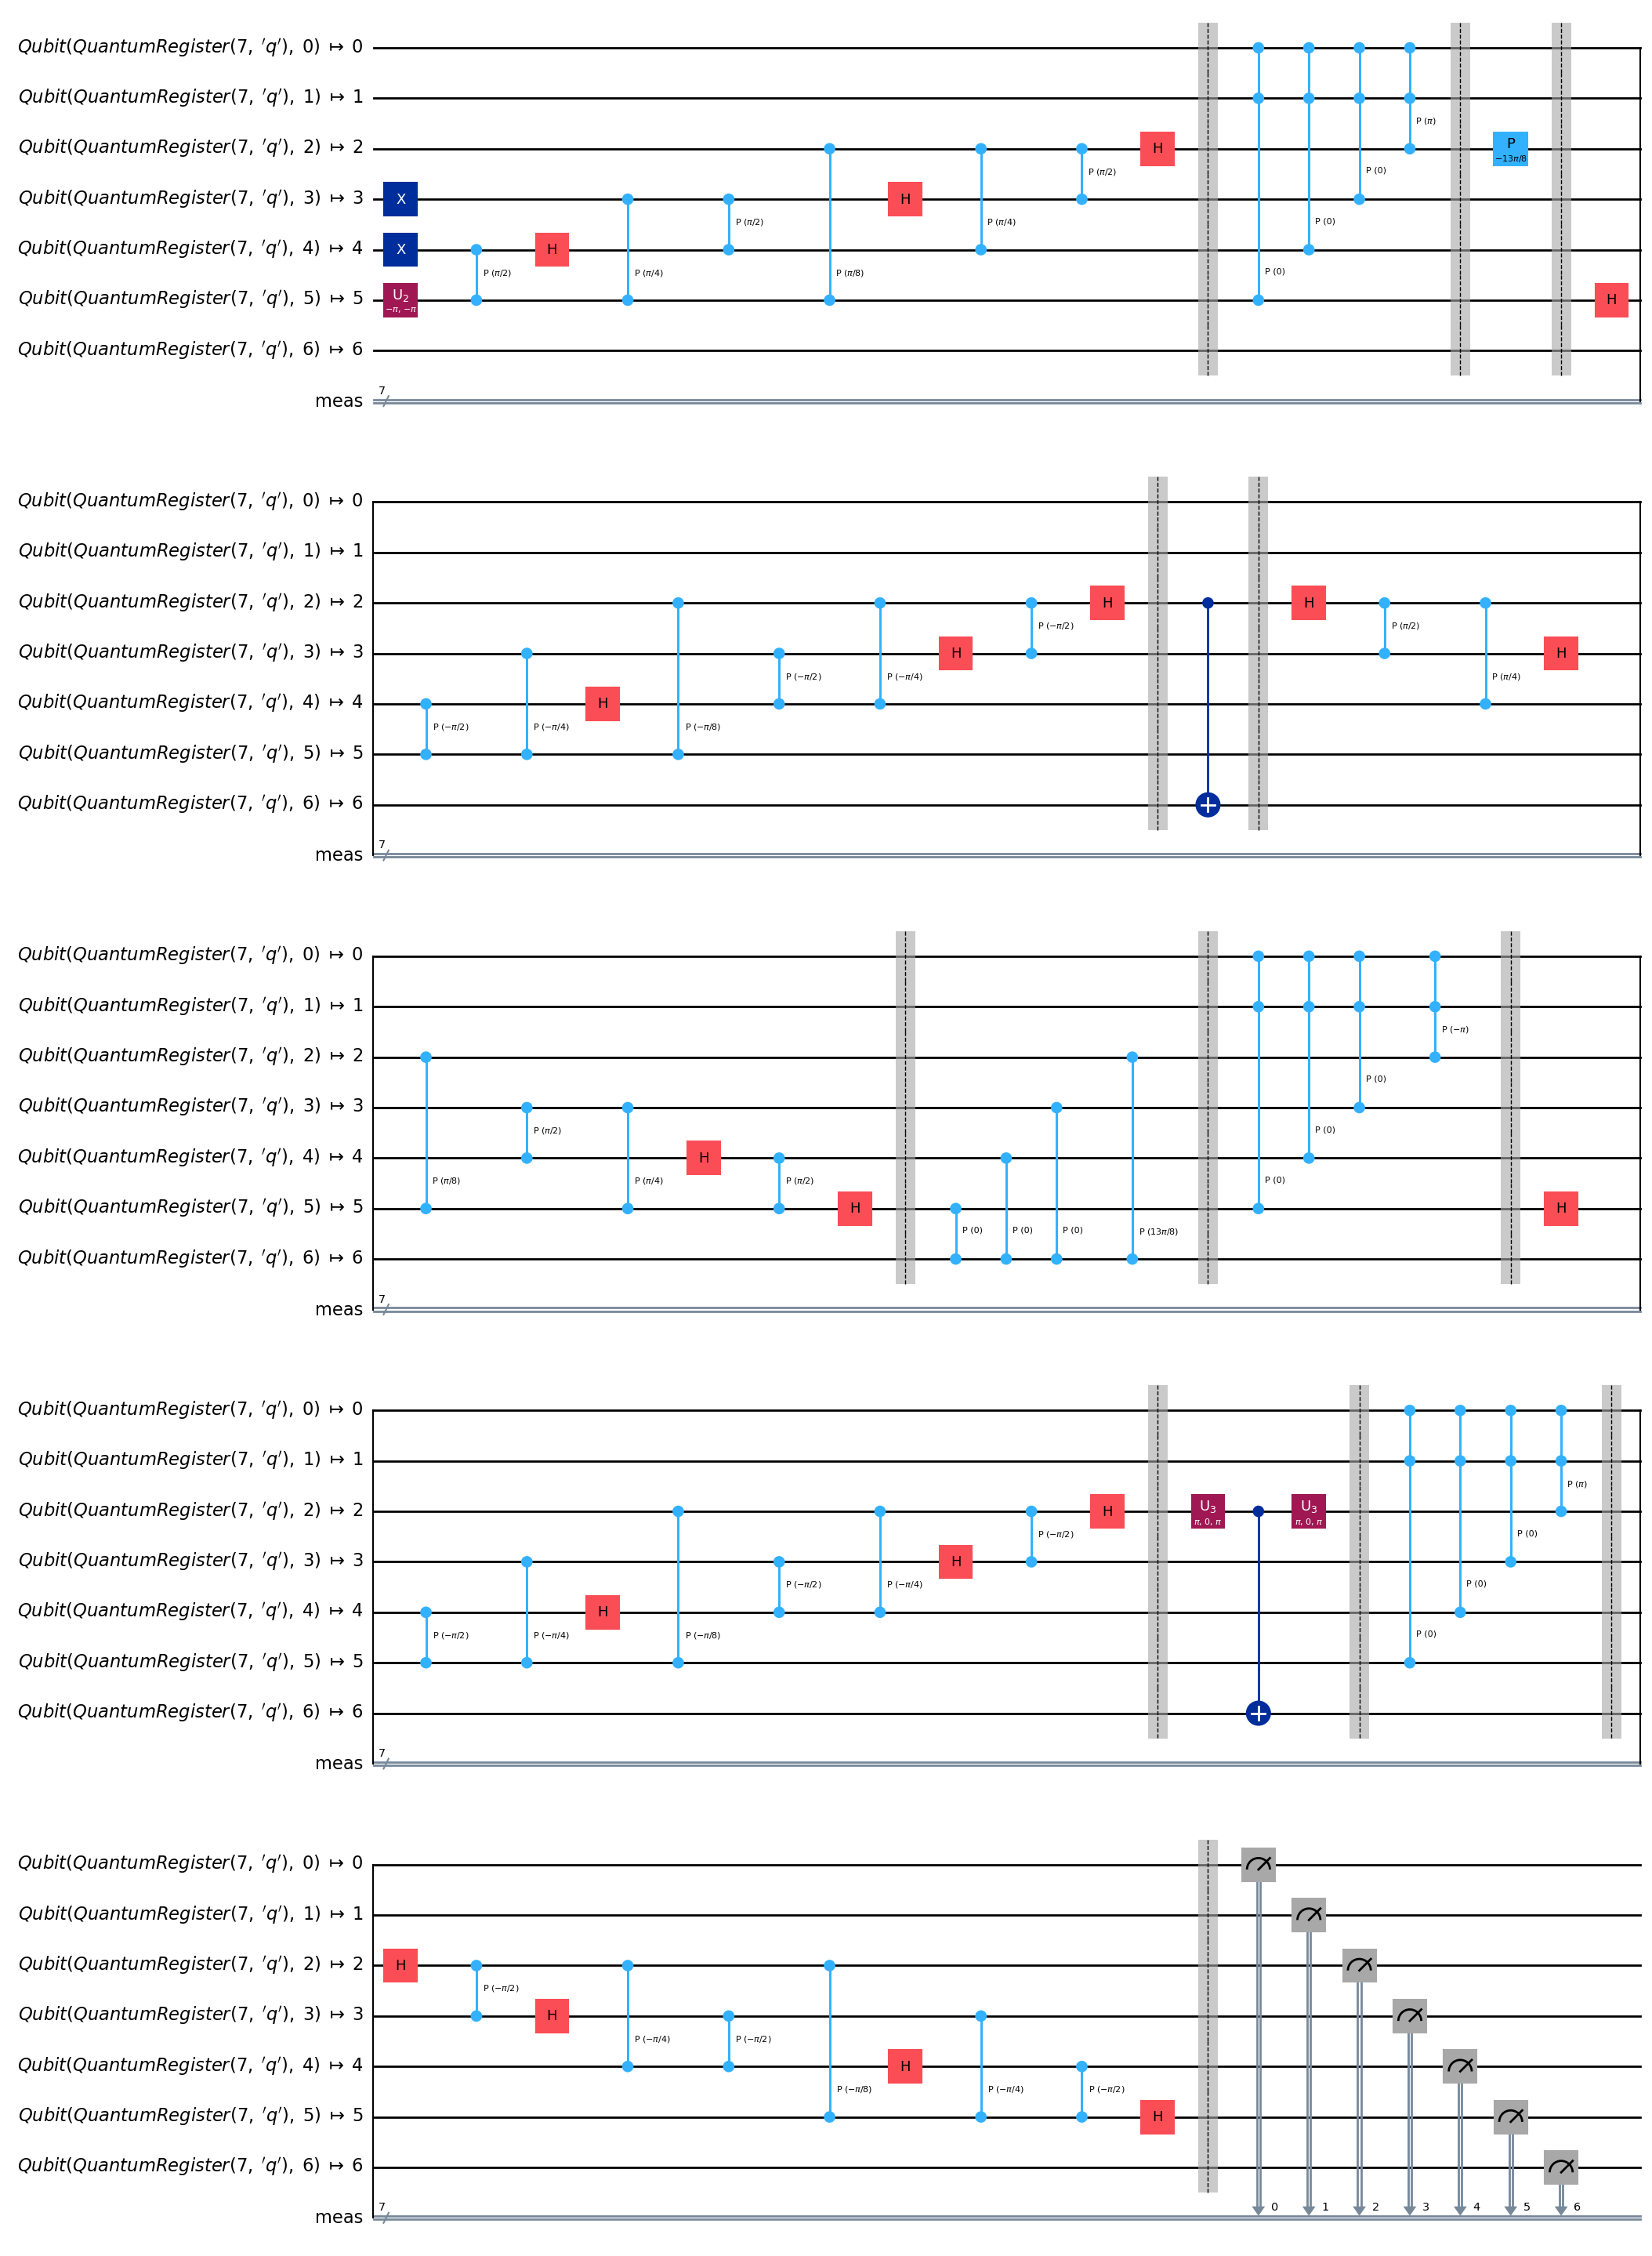

In [58]:
n = 13
N = math.ceil(math.log2(n))
a = 8
b = 7
qc = QuantumCircuit(N+3)
qft = QFT(N, do_swaps=True)
qft_inv = QFT(N, do_swaps=True, inverse=True)
bin_b = bin(b)[2:].zfill(N)
for i in range(N):
    if bin_b[i] == '1':
            qc.x(i+2)
qc.append(qft, list(range(2, N+2)))
qc.barrier()
modadder_circuit = ccphiADDmodN(a, n, N).decompose()
qc.append(modadder_circuit, list(range(N+3)))
qc.barrier()
qc.append(qft_inv, list(range(2, N+2)))
qc = transpile(qc, backend, optimization_level=2)
qc.measure_all()
qc.draw(output='mpl')


In [59]:
job = backend.run(transpile(qc, backend), shots=1024)
res_dict = job.result().get_counts()
print(res_dict)

{'0000000': 7, '1111100': 44, '0100000': 3, '1010000': 48, '1001100': 53, '1100000': 81, '1101000': 75, '1011100': 51, '1110100': 84, '0000100': 9, '0011000': 2, '1010100': 47, '1110000': 48, '0001100': 2, '1111000': 91, '1101100': 66, '1100100': 40, '1001000': 79, '1011000': 73, '1000000': 66, '1000100': 40, '0111000': 1, '0001000': 3, '0100100': 1, '0111100': 2, '0110100': 3, '0101100': 1, '0010000': 2, '0101000': 1, '0011100': 1}


In [60]:
# test adder
#n = 7
#N = math.ceil(math.log2(n))

#qc = QuantumCircuit(N+3)
#qft_inv = QFT(N, do_swaps=False, inverse=True)
#for a in range(n):
#    for b in range(n):
#        bin_b = bin(b)[2:].zfill(N)
#        for i in range(N):
#            if bin_b[i] == '1':
#                qc.x(i+2)
#        qc.h(list(range(2, N+2)))
#       modadder_circuit = ccphiADDmodN(a, n, N)
#        qc.append(modadder_circuit, list(range(N+3)))
#        qc.append(qft_inv, list(range(2, N+2)))
#        qc.measure_all()
#        job = backend.run(transpile(qc, backend), shots=1024)
#        res_dict = job.result().get_counts()
#        res = res_dict.most_frequent()[2:N+3]
#        #res_val = 0
#        #for i in range(N):
#        #    if res[i] == '1':
#        #        res_val += 2**(N-1-i)
#        #print(f"{a} + {b} = {res_val}")
#        print(res)                